# Document Understanding with NousHermes 2-Pro - Mistral 7B and Structured Generation

NOTE: Run Surya first to get the OCR outputs.

In [ ]:
import os
import json
import requests

import pandas as pd
import huggingface_hub
from PIL import Image
from transformers import AutoTokenizer

In [2]:
SYSTEM_PROMPT_FORMAT = "You are a helpful assistant that answers in JSON. Here's the json schema you must adhere to:\n<schema>\n<json_schema>\n<schema>"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    "leloy/Nous-Hermes-2-Pro-Docile-RASG-1ShotRetrieval-StructuredPrompt",
    trust_remote_code=True,
)

In [4]:
dataset_name = "mydoc"
surya_results_mydoc = json.load(
    open(
        f"inference_results/surya/{dataset_name}/surya/{dataset_name}/images/results.json",
        "r",
    )
)

In [5]:
def get_surya_ocr_text(image_path: str) -> str:
    surya_ocr = surya_results_mydoc[image_path[:-4].split("/")[-1]]
    surya_text = "\n".join(line["text"] for line in surya_ocr[0]["text_lines"])
    return surya_text

In [6]:
def extract_key_from_question(question: str) -> str:
    question = " ".join(question.split(" "))
    assert question.startswith("<image>\nWhat is the ")
    assert question.endswith(" in the image?")
    key = question[len("<image>\nWhat is the "):-len(" in the image?")]
    if key.startswith("[") or key.startswith("‘"):
        key = key[1:]
    if key.endswith("?"):
        key = key[:-1]
    return (
        key
        .replace(" ", "_")
        .replace("_no", "_number")
        .replace("_$", "_dollars")
    )

In [7]:
# "1_reasoning": {
#                         "type": "string",
#                     },
#                     f"2_{key}": {
#                         "type": "integer" if key == "page" else "string",
#                         "description": "The answer, EXACTLY as it appears in the document.",
#                         "maxLength": max_length,
#                     }

In [8]:
def build_doc_extraction_tool(key: str, max_length: int=100):
    return {
        "type": "function",
        "function": {
            "name": "doc_extraction_tool",
            "description": "Extract information from a document",
            "parameters": {
                "type": "object",
                "properties": {
                    key : {
                        "type": "integer" if key == "page" else "string",
                        "description": "The answer, EXACTLY as it appears in the document.",
                        "maxLength": max_length,
                    }
                },
                "required": [key],
            },
        }
    }

In [9]:
API_URL = "https://asreb1rtjp81xsv2.us-east-1.aws.endpoints.huggingface.cloud"
headers = {
	"Accept" : "application/json",
	"Authorization": f"Bearer {huggingface_hub.get_token()}",
	"Content-Type": "application/json" 
}

def query(payload):
	response = requests.post(API_URL, headers=headers, json=payload)
	return response.json()

In [10]:
def run_inference(image_path, question, seed=0, max_length: int=100):
    key = extract_key_from_question(question)
    print(f"{key = }")
    if key.strip() == "":
        return "This question is unanswerable."

    tool = build_doc_extraction_tool(key, max_length)

    system_prompt = SYSTEM_PROMPT_FORMAT.replace(
        "<json_format>",
        json.dumps(tool["function"]["parameters"]["properties"]),
    )

    messages = [
        {
            "role": "system",
            "content": system_prompt,
        },
        {
            "role": "user",
            "content": f"{get_surya_ocr_text(image_path)}.\n\n{question}",
        }
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

    # This version of TGI uses an older version of Outlines
    # which re-orders the keys in the JSON in alphabetical order.
    # Hence the prefixes in the keys in the grammer
    response = query({
        "inputs": prompt,
        "parameters": {
            "return_full_text": False,
            "max_new_tokens": 128,
            "top_p": 0.95,
            "frequency_penalty": 0,
            "presence_penalty": 0,
            "grammar": {
                "type": "json",
                "value": tool["function"]["parameters"],
            }
        }
    })
    print(f"{response = }")

    return json.loads(response[0]["generated_text"])[key]

In [11]:
image_path = "data/raw_datasets/mydoc/images/2475c566901d68a77a8f16cfa498cb165201890e980fa2c4aa1e1e9c8c60fbc8.png"

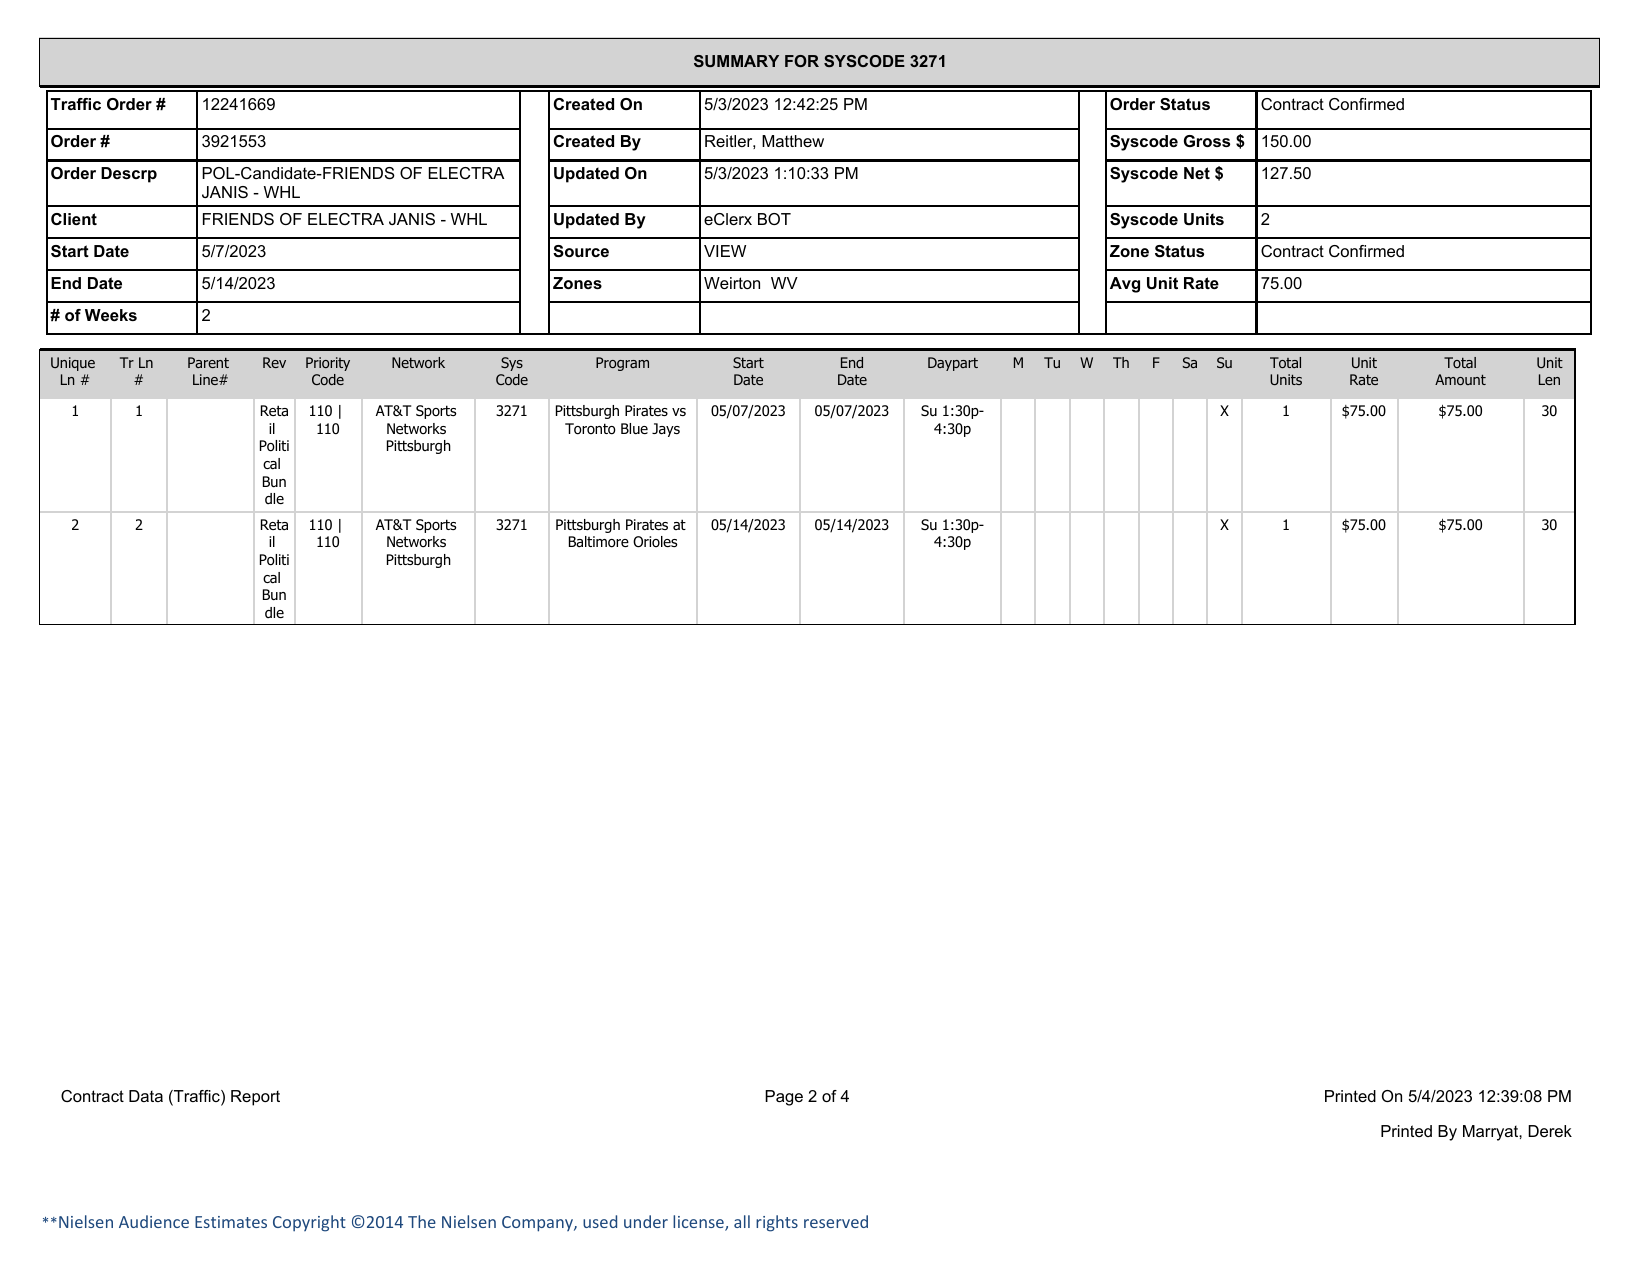

In [12]:
image = Image.open(image_path)
image

In [13]:
surya_text = get_surya_ocr_text(image_path)
surya_text

'SUMMARY FOR SYSCODE 3271\nTraffic Order #\n12241669\nCreated On\n5/3/2023 12:42:25 PM\nOrder Status\nContract Confirmed \nOrder #\n3921553\nCreated By\nReitler, Matthew\nSyscode Gross $ \n150.00\nPOL-Candidate-FRIENDS OF ELECTRA\nOrder Descrp\nUpdated On\n5/3/2023 1:10:33 PM\nSyscode Net $\n127.50\nJANIS - WHL\nFRIENDS OF ELECTRA JANIS - WHL\nClient\n| Updated By\neClerx BOT\nSyscode Units\nStart Date\n5/7/2023\nSource\nVIEW\nZone Status\nContract Confirmed\nEnd Date\n5/14/2023\n Zones\nWeirton  WV\nAvg Unit Rate\n75.00\n# of Weeks\n2\nUnique\nTr Ln\nParent\nRev\nPriority\nNetwork\nSys\nProgram\nStart\n End\nDaypart\nSa  Su\nTotal\n Unit\nTotal\nUnit\nM\n Tu W Th F\nLine#\n Code\nDate\nDate\nUnits\nAmount\nLn #\n Code\nRate\nLen\n#\n110 |\nAT&T Sports\n3271\nPittsburgh Pirates vs\n05/07/2023\n05/07/2023\nSu 1:30p-\n$75.00\n$75.00\n30\nReta\n1\nX\n1\n1\nToronto Blue Jays\nNetworks\n4:30p\n110\nil\nPoliti\nPittsburgh\ncal\nBun\ndle\nAT&T Sports\n3271\nPittsburgh Pirates at\n05/14/2023\n

In [ ]:
run_inference(
    image_path,
    "<image>\nWhat is the [order descrp in the image?",
    max_length=30,
)

In [15]:
dataset_name = "mydoc"
dataset_path = os.path.join("data/raw_datasets", dataset_name, "annot_wo_answer.json")
print(dataset_path)
assert os.path.exists(dataset_path)

df_data = pd.read_json(dataset_path)

data/raw_datasets/mydoc/annot_wo_answer.json


In [16]:
!mkdir -p inference_results/nous-hermes-docile

In [17]:
failed_idx = set()

In [18]:
# failed_idx = set()
for idx, row in df_data.iterrows():
    id = row["id"]
    answer_txt_path = f"inference_results/nous-hermes-docile/{id}.txt"

    image_path = f"data/raw_datasets/{dataset_name}/images/{row['image']}"
    question = row["conversations"][0]["value"]

    if os.path.exists(answer_txt_path):
        continue
    print(image_path)
    print(id, idx, question)

    try:
        answer = run_inference(image_path, question, seed=7283703)
        print(f"{answer = }")
        with open(answer_txt_path, "w") as f:
            f.write(str(answer))
    except Exception as e:
        print(">>>>>>> ERROR", idx, row, e, "<<<<<<<")
        failed_idx.add(idx)
    print("---------")